## Deep Dive into TransformerLens: Understanding and Applying Mechanistic Interpretability

Author: Ankita Sharma; 
Date: November 04, 2025; 
GDSC Glassbox-LLM

### Table of Contents
1. Introduction
2. What is TransformerLens?
3. Setting Up the Environment
4. Basic TransformerLens Usage Breakdown
5. Understanding Transformer Internals
6. Mechanistic Interpretability Techniques
7. Case Study: Analyzing Real AI Systems
8. Advanced Applications
9. Conclusion

### 1. Introduction
This notebook presents a detailed exploration of how the TransformerLens librabry enables researchers to examine the internal workings of transformer models. The goal is to simplify complex mechanisms and demonstrate how TransformerLens can be used to better understand the behavior and structure of modern AI systems.
<br>

**Research Objectives:**
-  Understand the architecture and design principles of TransformerLens 
-  Learn how to probe and analyze transformer models
-  Apply interpretability techniques to real AI systems

### 2. What is TransformerLens?
TransformerLens is a Python library desgined for *mechansitic interpretability* of transformer models. *Mechanistic Interpretability* aims to reverse-engineer neural networks into human-understandable algorithms and circuits. To summarize, TransformerLens allow us to understand neural networks by giving us tool to:
-  Load and run transformer models
    - You can use TransformerLens to open (or “load”) a transformer model and make it run (generate outputs) — just like running a small version of GPT.
-  Access intermediate activations
    -  While the model is running, TransformerLens lets you peek inside and see what happens in each layer, like checking the “thoughts” the model has while forming its answer.
-  Perform casual intervention experiments
    - You can test what happens if you change something inside the model (for example, modify a neuron’s output) and see how it affects the final result. This helps find cause-and-effect relationships inside the model.
-  Analyze model components and circuits
    - You can study specific parts of the model (like attention heads or layers) to understand what each one does, and how they work together — similar to tracing an electrical circuit.

In [1]:
# Let's start by importing essential libraries used for analyzing and visualizing transformer models.
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import plotly.express as px

print("PyTorch version:", torch.__version__)

ModuleNotFoundError: No module named 'transformer_lens'

### 3. Setting Up the Environment

In [ ]:
#Description: Checking if the GPU is available for use otherwise the model will be run using the CPU.”
# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


Loading GPT-2 Small Model(lightweight version of GPT-2)

In [ ]:
# Load a pre-trained model
model_name = "gpt2-small"  # We'll start with a smaller model for faster experimentation
model = HookedTransformer.from_pretrained(model_name, device=device)

# Let's examine the model architecture
print("\nModel architecture:")
print(f"Model: {model_name}")
print(f"Layers: {model.cfg.n_layers}") #The number of transformer blocks (GPT-2 Small has 12).
print(f"Heads: {model.cfg.n_heads}") #The number of attention heads per layer each head focuses on different word relationships.
print(f"Dimensions: {model.cfg.d_model}") #The size of the hidden representation (how large each vector of numbers is).
print(f"Vocabulary size: {model.cfg.d_vocab}") #The number of unique tokens (words/subwords) the model understands.

Loaded pretrained model gpt2-small into HookedTransformer

Model architecture:
Model: gpt2-small
Layers: 12
Heads: 12
Dimensions: 768
Vocabulary size: 50257


### 4. Basic TransformerLens Usage Breakdown

In [ ]:
# The goal is to see what word the model predicts next.
# Example text to analyze
text = "The capital of France is"
print(f"Input text: '{text}'")

# Tokenize the input
#Tokenization = converting words into numbers the model understands.
tokens = model.to_tokens(text)
#Then the model converts the text into:
    #  ['<|endoftext|>', 'The', ' capital', ' of', ' France', ' is']
#and the tensor, where each number is the ID of that token in the model’s vocabulary:
    #  tensor([[50256, 464, 3139, 286, 4881, 318]])
print(f"Tokens: {tokens}")
print(f"Tokenized: {model.to_str_tokens(text)}")


# Run the model and get predictions
logits, cache = model.run_with_cache(text)
#Code Breakdown:
#logits = the raw output scores for the next token (before applying softmax).
#cache = stores intermediate activations (internal model data at each layer).
#       This is one of TransformerLens’s superpowers, it lets you look inside the “thought process” of the model.
print(f"Logits shape: {logits.shape}")
#this prints: Logits shape: torch.Size([1, 6, 50257])
#where 1 = batch size (one sentence)
     # 6 = number of tokens in the input
    # 50257 = vocabulary size, the model predicts one of these tokens next


# Get the next token prediction
next_token_logits = logits[0, -1, :]
#Logits = raw model scores before converting to probabilities
next_token_probs = torch.softmax(next_token_logits, dim=0)
top_k = 5
top_probs, top_indices = torch.topk(next_token_probs, top_k)


print("\nTop predictions:")
for i in range(top_k):
    token_str = model.to_string(top_indices[i])
    prob = top_probs[i].item()
    print(f"{i+1}. '{token_str}' - {prob:.3f} ({prob*100:.1f}%)")

Input text: 'The capital of France is'
Tokens: tensor([[50256,   464,  3139,   286,  4881,   318]])
Tokenized: ['<|endoftext|>', 'The', ' capital', ' of', ' France', ' is']
Logits shape: torch.Size([1, 6, 50257])

Top predictions:
1. ' now' - 0.048 (4.8%)
2. ' the' - 0.037 (3.7%)
3. ' a' - 0.035 (3.5%)
4. ' home' - 0.031 (3.1%)
5. ' in' - 0.027 (2.7%)


<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
C:\Users\sharm\AppData\Local\Temp\ipykernel_15972\699491523.py:3: SyntaxWarning: invalid escape sequence '\i'
  display(Image(filename="C:\images\TransformerLens_on_GPT-2.png"))


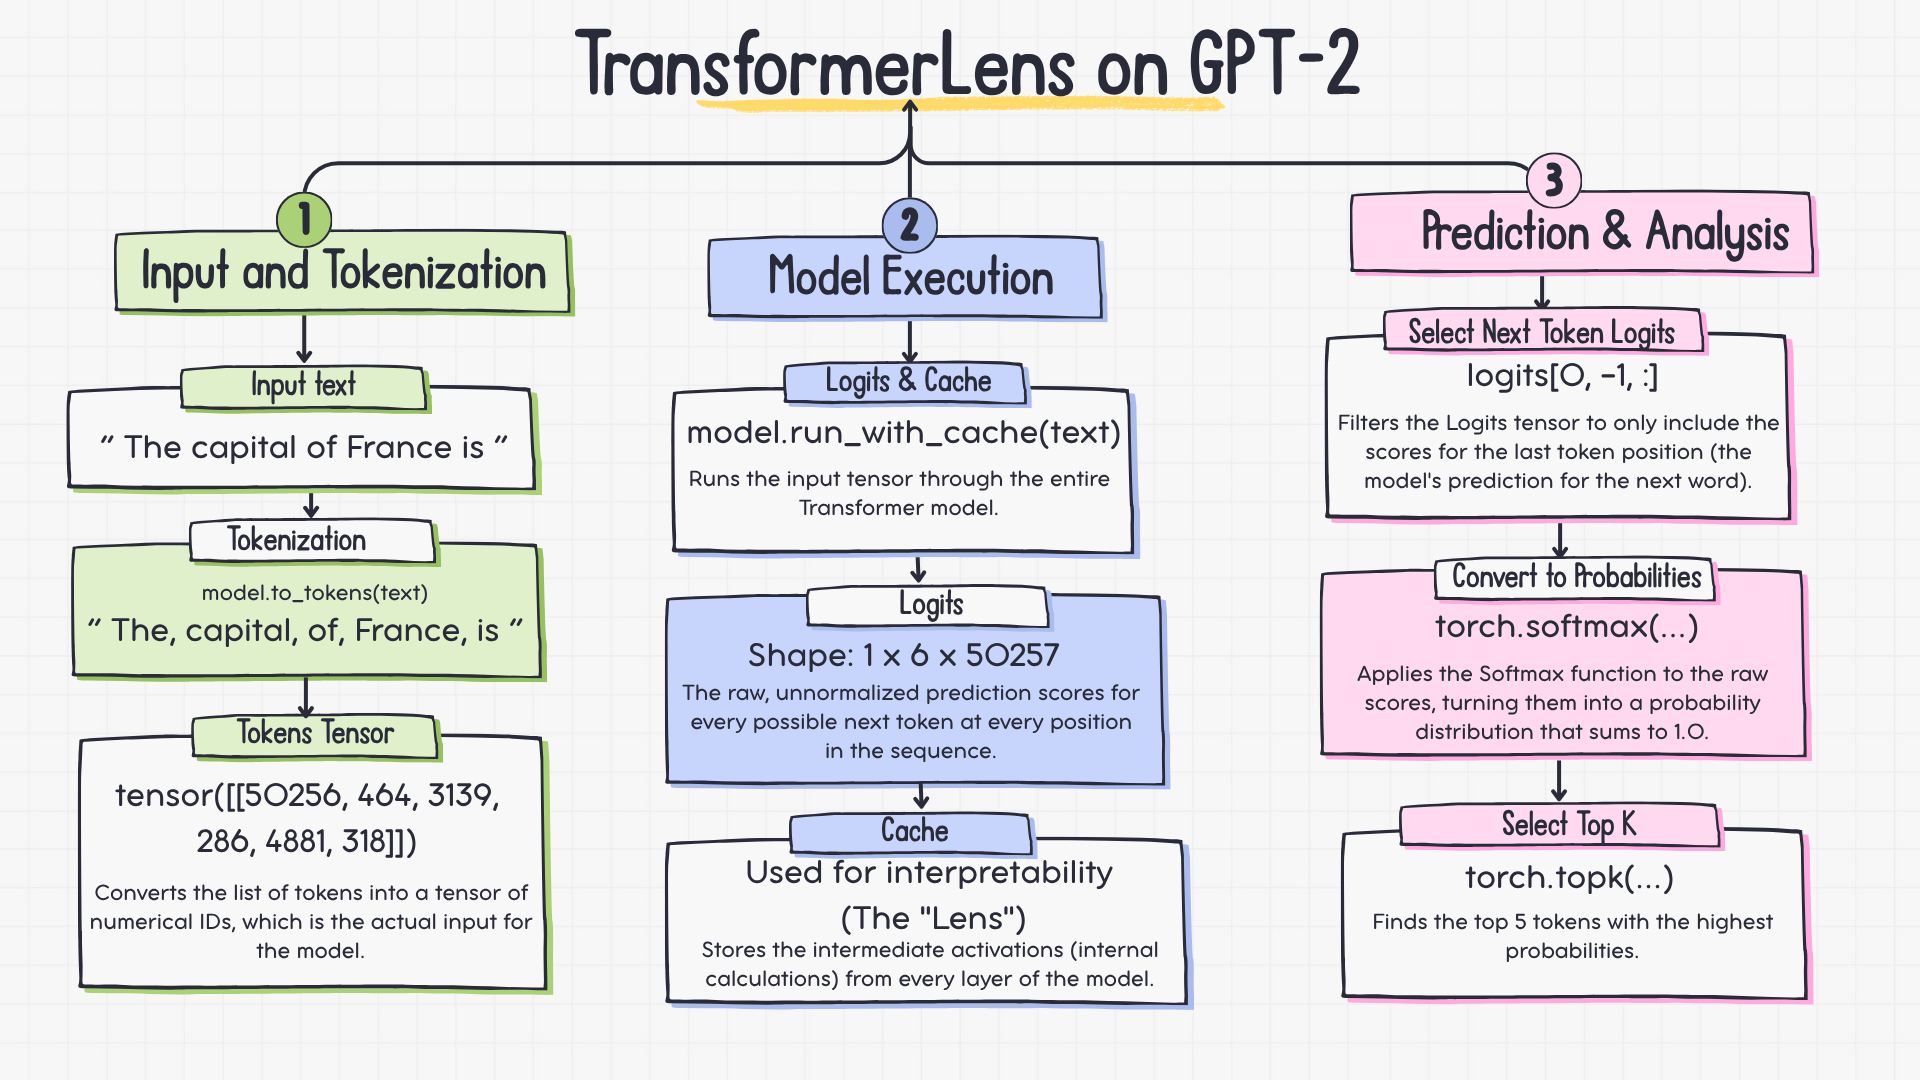

In [ ]:
#GPT Model Prediction Process (Using TransformerLens)
from IPython.display import Image, display
display(Image(filename="C:\images\TransformerLens_on_GPT-2.png"))

**Breakdown: cache keys**<br>
*hook_embed*	  Activation after the token embedding layer<br>
*hook_pos_embed*    	Positional embeddings added to token vectors<br>
*blocks.0.hook_resid_pre*	   Residual stream before any transformations in block 0<br>
*blocks.0.ln1.hook_scale*	  Scale parameter from LayerNorm in block 0<br>
*blocks.0.ln1.hook_normalized*  	Normalized residuals after LayerNorm in block 0<br>
*blocks.0.attn.hook_q*	  Query vectors for attention in block 0<br>
*blocks.0.attn.hook_k*	  Key vectors for attention in block 0<br>
*blocks.0.attn.hook_v*	  Value vectors for attention in block 0<br>
*blocks.0.attn.hook_attn_scores*	  Raw attention scores before softmax<br>
*blocks.0.attn.hook_pattern*	 Final attention probabilities after 
softmax<br>

**Key points**
<br>
-  The cache is like a recording of the model’s “thoughts” as it processes the input.
-  In this example, there are 208 cache entries covering every layer, head, and component.
-  These activations can be used for:
    -  Visualizing attention patterns
    -  Studying residual streams
    -  Performing causal experiments like activation patching

**Analyzing Activation Patterns**<br>
This code is exploring what happens inside a specific layer of the transformer, specifically the residual stream and attention patterns.

Residual pre (layer 0) shape: torch.Size([1, 6, 768])
Residual pre norms: tensor([[10.3312,  5.7080,  5.8055,  5.0854,  5.4251,  4.8514]])
Attention pattern (layer 0) shape: torch.Size([1, 12, 6, 6])


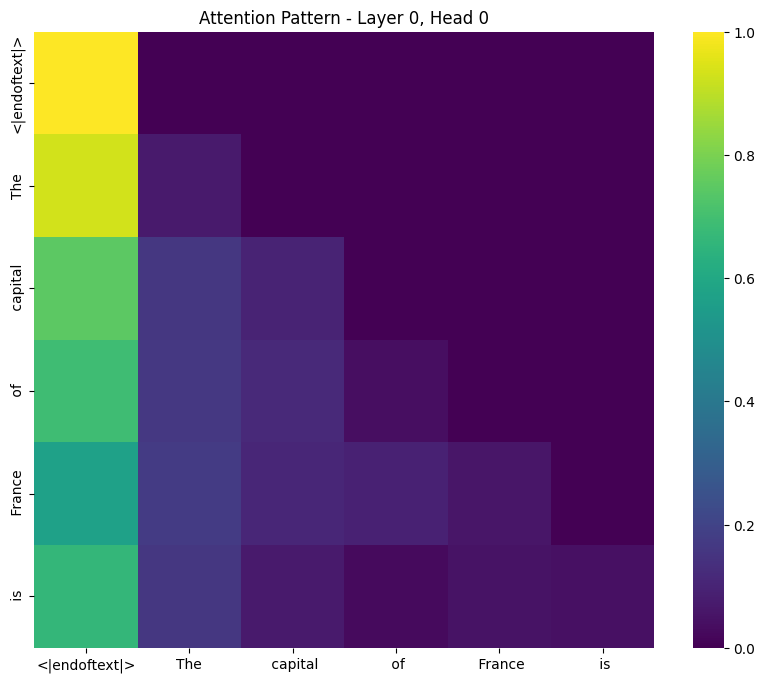

In [ ]:
# Let's examine a specific activation pattern
def analyze_activation_patterns(cache, layer_idx=0):
    """Analyze activation patterns for a specific layer"""
    # Get residual stream activations
    resid_pre_key = f"blocks.{layer_idx}.hook_resid_pre"
    resid_post_key = f"blocks.{layer_idx}.hook_resid_post"
    
    if resid_pre_key in cache:
        resid_pre = cache[resid_pre_key]
        print(f"Residual pre (layer {layer_idx}) shape: {resid_pre.shape}")
        print(f"Residual pre norms: {torch.norm(resid_pre, dim=-1)}")
    
    # Get attention pattern for first head
    attn_pattern_key = f"blocks.{layer_idx}.attn.hook_pattern"
    if attn_pattern_key in cache:
        attn_pattern = cache[attn_pattern_key]
        print(f"Attention pattern (layer {layer_idx}) shape: {attn_pattern.shape}")
        
        # Visualize attention pattern for first head
        plt.figure(figsize=(10, 8))
        sns.heatmap(attn_pattern[0, 0].detach().cpu().numpy(), 
                   cmap='viridis', xticklabels=model.to_str_tokens(text),
                   yticklabels=model.to_str_tokens(text))
        plt.title(f"Attention Pattern - Layer {layer_idx}, Head 0")
        plt.show()

analyze_activation_patterns(cache, layer_idx=0)

### Code Breakdown:
The function analyze_activation_patterns takes a snapshot of the model's internal state (the cache) and inspects two key things for a given layer (here, layer 0):
1. The Residual Stream (resid_pre): This is the information flowing into the layer.
 -  The output shape: [1, 6, 768] tells us: 1 batch, 6 tokens in the sequence, and 768 values in the embedding vector for each token.
 -  The "Residual pre norms" are the magnitude (length) of each token's vector. The first token (10.33) has a much higher norm, which is common as it often carries special positioning information.

2. The Attention Pattern (hook_pattern): This shows which tokens each token is looking at.
-  The output shape: [1, 12, 6, 6] tells us: 1 batch, 12 attention heads in this layer, and a 6x6 grid for each head.

-  The heatmap is a visualization of this 6x6 grid for the first head (attn_pattern[0, 0]). It shows, for each token (on the y-axis), how it distributes its attention across all tokens (on the x-axis).

In short: The code revealed the dimensionality of the data flowing into the layer and created a visual map of the "attention focus" for one head in that layer, showing the relationships between the words in your sentence.

### 5. Understanding Transformer Internals
This section explores the internal structure of transformer models, examining each component to understand how they contribute to the model’s overall behavior.

**5.1 Attention Mechanism Analysis**

Analyzing attention in layer 0
Attention pattern shape: torch.Size([1, 12, 10, 10])


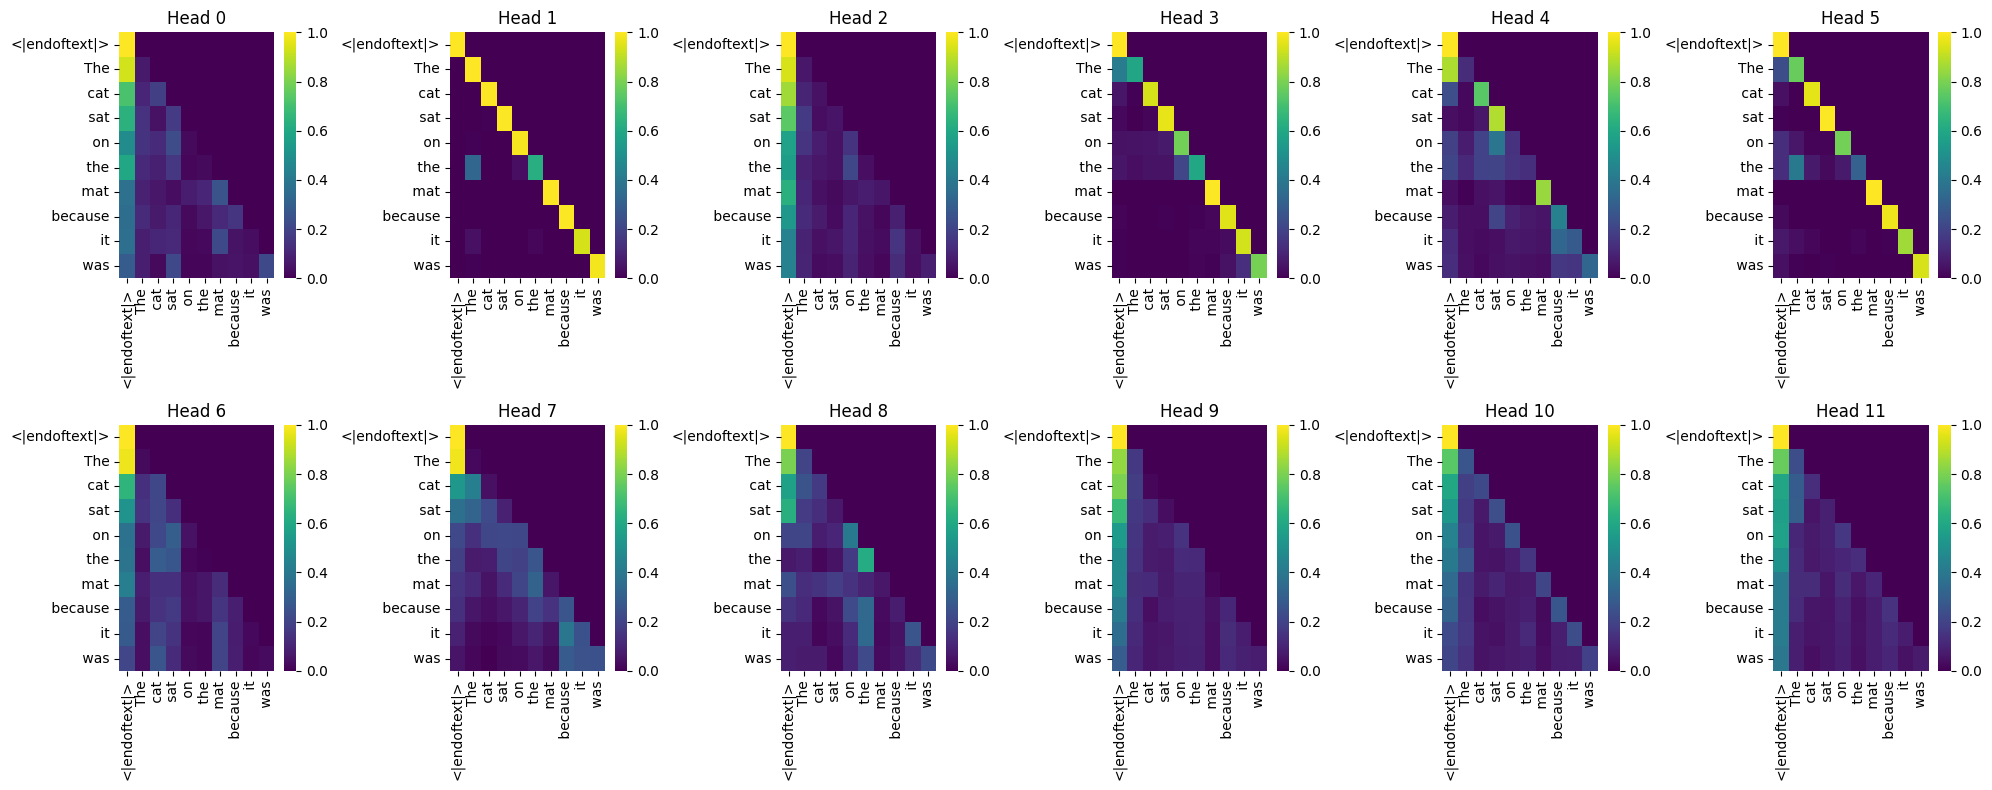

In [ ]:
def analyze_attention_mechanism(model, text, layer_to_analyze=0):
    """Comprehensive analysis of attention mechanism"""
    tokens = model.to_tokens(text)
    _, cache = model.run_with_cache(text)
    
    # Get attention patterns for specified layer
    attn_pattern_key = f"blocks.{layer_to_analyze}.attn.hook_pattern"
    attn_pattern = cache[attn_pattern_key]
    
    print(f"Analyzing attention in layer {layer_to_analyze}")
    print(f"Attention pattern shape: {attn_pattern.shape}")  # [batch, head, pos, pos]
    
    # Analyze each attention head
    n_heads = attn_pattern.shape[1]
    n_tokens = attn_pattern.shape[2]
    
    fig, axes = plt.subplots(2, n_heads//2, figsize=(20, 8))
    axes = axes.flatten()
    
    token_labels = model.to_str_tokens(text)
    
    for head_idx in range(n_heads):
        attn_data = attn_pattern[0, head_idx].detach().cpu().numpy()
        
        sns.heatmap(attn_data, ax=axes[head_idx], cmap='viridis',
                   xticklabels=token_labels, yticklabels=token_labels)
        axes[head_idx].set_title(f'Head {head_idx}')
    
    plt.tight_layout()
    plt.show()
    
    return attn_pattern

# Analyze attention for our example
attn_patterns = analyze_attention_mechanism(model, "The cat sat on the mat because it was")

**5.2 Feed-Forward Network Analysis**

FFN pre-activation shape: torch.Size([1, 7, 3072])


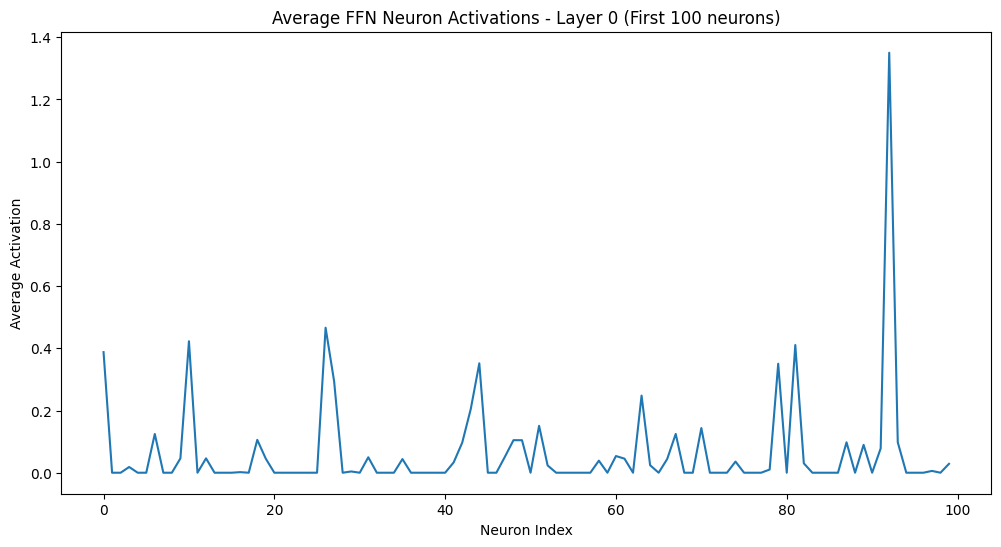

Top 10 activated neurons:
  Neuron 2845: 2.2645
  Neuron 1612: 1.8714
  Neuron 486: 1.7862
  Neuron 1115: 1.3864
  Neuron 92: 1.3503
  Neuron 1344: 1.0415
  Neuron 179: 0.9297
  Neuron 705: 0.9164
  Neuron 1396: 0.8910
  Neuron 2535: 0.8746


In [ ]:
def analyze_ffn(model, text, layer_to_analyze=0):
    """Analyze the Feed-Forward Network components"""
    _, cache = model.run_with_cache(text)
    
    # Get FFN activations
    ffn_pre_key = f"blocks.{layer_to_analyze}.mlp.hook_pre"
    ffn_post_key = f"blocks.{layer_to_analyze}.mlp.hook_post"
    
    if ffn_pre_key in cache:
        ffn_pre = cache[ffn_pre_key]
        print(f"FFN pre-activation shape: {ffn_pre.shape}")
        
        # Analyze neuron activations
        neuron_activations = torch.relu(ffn_pre[0])  # ReLU activation
        avg_activation_per_neuron = neuron_activations.mean(dim=0)
        
        plt.figure(figsize=(12, 6))
        plt.plot(avg_activation_per_neuron.detach().cpu().numpy()[:100])  # First 100 neurons
        plt.title(f'Average FFN Neuron Activations - Layer {layer_to_analyze} (First 100 neurons)')
        plt.xlabel('Neuron Index')
        plt.ylabel('Average Activation')
        plt.show()
        
        # Show top activated neurons
        top_neurons = torch.topk(avg_activation_per_neuron, 10)
        print("Top 10 activated neurons:")
        for i, (activation, idx) in enumerate(zip(top_neurons.values, top_neurons.indices)):
            print(f"  Neuron {idx}: {activation:.4f}")

analyze_ffn(model, "The artificial intelligence system learned to")

### 6. Mechanistic Interpretability Techniques
This section examines advanced interpretability methods supported by TransformerLens, which help uncover how specific components of a transformer influence its behavior.

**6.1 Activation Patching**
Activation patching is a technique for testing causal relationships within a model. It involves replacing specific activations and observing how these changes affect the model’s outputs.

Patching layers: 100%|██████████| 12/12 [00:00<00:00, 14.75it/s]


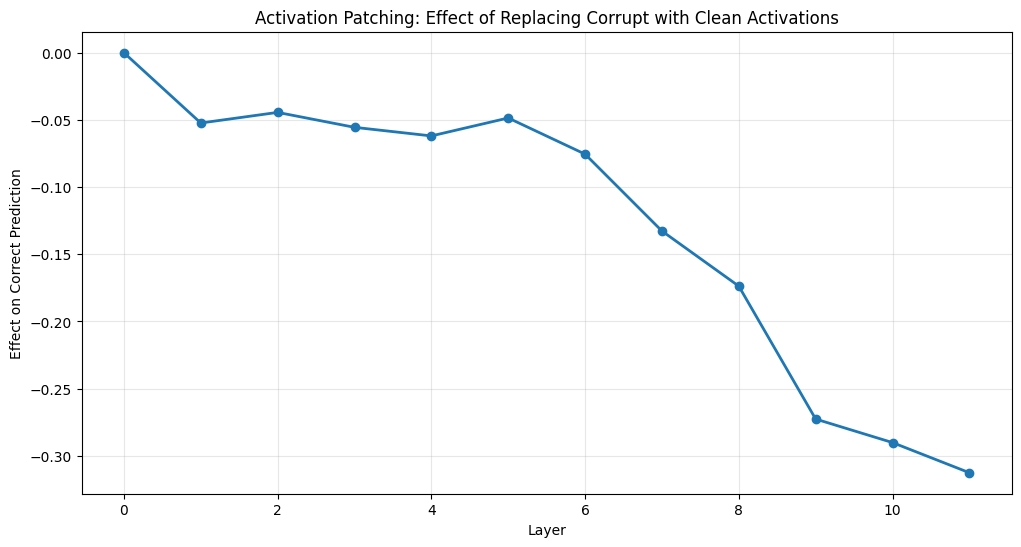

In [ ]:
def activation_patching_experiment(model, clean_text, corrupt_text, position_to_patch=-1):
    """
    Perform activation patching to understand causal effects.
    
    Args:
        model: The transformer model
        clean_text: Text that produces the "correct" behavior
        corrupt_text: Text that produces different behavior
        position_to_patch: Which position to patch (-1 for last position)
    """
    
    # Get clean and corrupt activations
    clean_logits, clean_cache = model.run_with_cache(clean_text)
    corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_text)
    
    # Define patching hook
    def patch_hook(activation, hook, position=position_to_patch):
        activation[:, position, :] = clean_cache[hook.name][:, position, :]
        return activation
    
    # Test patching at different layers
    layers = list(range(model.cfg.n_layers))
    patching_effects = []
    
    for layer in tqdm(layers, desc="Patching layers"):
        # Patch residual stream at specified layer and position
        hook_fn = lambda activation, hook: patch_hook(activation, hook, position_to_patch)
        
        # Run model with patching
        patched_logits = model.run_with_hooks(
            corrupt_text,
            fwd_hooks=[(f"blocks.{layer}.hook_resid_pre", hook_fn)]
        )
        
        # Calculate effect on correct prediction
        clean_next_token = clean_logits[0, -1].argmax()
        corrupt_score = corrupt_logits[0, -1, clean_next_token]
        patched_score = patched_logits[0, -1, clean_next_token]
        
        effect = patched_score - corrupt_score
        patching_effects.append(effect.item())
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(layers, patching_effects, marker='o', linewidth=2)
    plt.xlabel('Layer')
    plt.ylabel('Effect on Correct Prediction')
    plt.title('Activation Patching: Effect of Replacing Corrupt with Clean Activations')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return patching_effects

# Example: Testing subject-verb agreement
clean_sentence = "The dog chases the ball"
corrupt_sentence = "The dogs chases the ball"  # Incorrect grammar
effects = activation_patching_experiment(model, clean_sentence, corrupt_sentence)

**6.2 Direct Logit Attribution**

Analyzing contribution to token: ' a' (index 257)
Final logit for ' a': 14.5375
Direct contribution: 151.8635


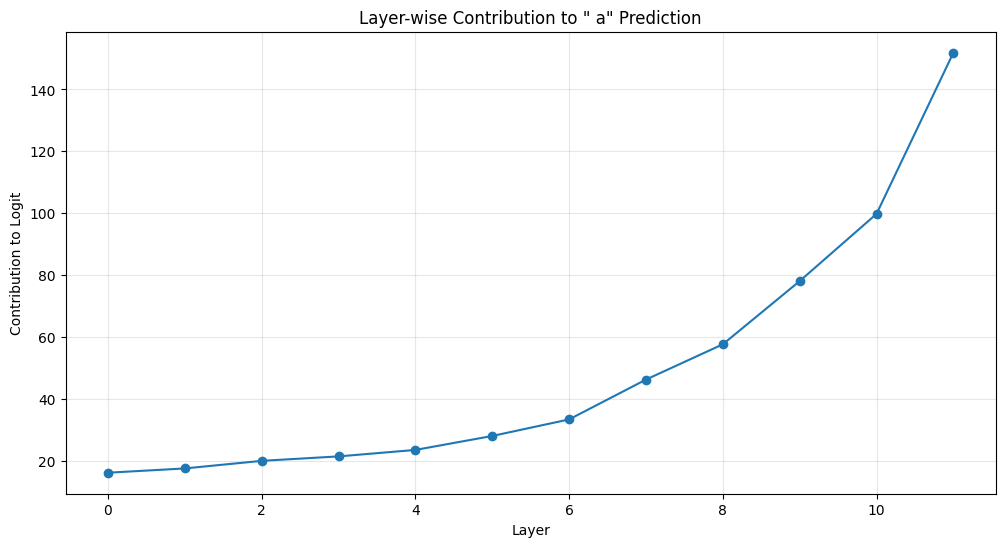

In [ ]:
def logit_attribution_analysis(model, text, target_token_str=None):
    """
    Analyze how different components contribute to final logits.
    """
    tokens = model.to_tokens(text)
    logits, cache = model.run_with_cache(text)
    
    if target_token_str is None:
        # Use the top predicted next token
        next_token_idx = logits[0, -1].argmax()
        target_token_str = model.to_string(next_token_idx)
    else:
        next_token_idx = model.to_single_token(target_token_str)
    
    print(f"Analyzing contribution to token: '{target_token_str}' (index {next_token_idx})")
    
    # Decompose logits by component
    residual_final = cache["blocks.11.hook_resid_post"][0, -1]  # Final residual stream
    W_U = model.W_U  # Unembedding matrix
    
    # Direct contribution from final residual stream
    direct_contribution = (residual_final @ W_U[:, next_token_idx]).item()
    final_logit = logits[0, -1, next_token_idx].item()
    
    print(f"Final logit for '{target_token_str}': {final_logit:.4f}")
    print(f"Direct contribution: {direct_contribution:.4f}")
    
    # Analyze layer contributions
    layer_contributions = []
    for layer in range(model.cfg.n_layers):
        layer_residual = cache[f"blocks.{layer}.hook_resid_post"][0, -1]
        layer_contribution = (layer_residual @ W_U[:, next_token_idx]).item()
        layer_contributions.append(layer_contribution)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(model.cfg.n_layers), layer_contributions, marker='o')
    plt.xlabel('Layer')
    plt.ylabel('Contribution to Logit')
    plt.title(f'Layer-wise Contribution to "{target_token_str}" Prediction')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return layer_contributions

# Analyze logit attribution
contributions = logit_attribution_analysis(model, "The weather today is")

### Code Breakdown

This code performs **logit attribution** - it traces back how the model's final prediction is built up across different layers. Here's the step-by-step:

1. **Target Identification**: We find which token the model wants to predict (in this case, `' a'`)

2. **Component Breakdown**: We take the final residual stream (the model's "thought" before the output layer) and measure how much it contributes to the target token's score

3. **Layer-by-Layer Analysis**: We go backwards through each layer and measure how much that layer's output contributes to the final prediction

The graph shows us **which layers are most responsible** for steering the model toward this specific prediction. Peaks indicate layers that added significant evidence for predicting `' a'` after the input "The weather today is".


### 7. Case Study: Analyzing Real AI Systems
This section applies the previously discussed techniques to examine specific behaviors in language models, providing practical insights into how these models process and generate information.

**7.1 Analyzing Copying Mechanisms**


Text: 'Repeat after me: hello hello'
Predicted: '!' (prob: 0.132)


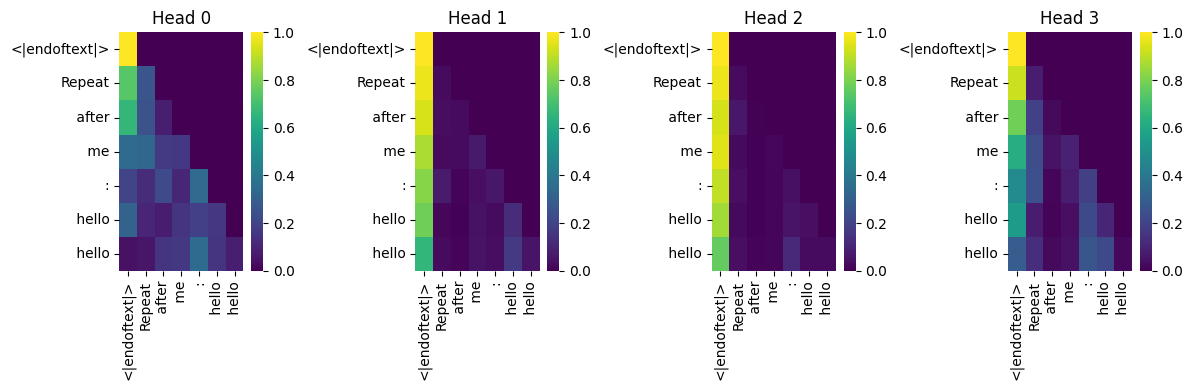


Text: 'Repeat after me: hello world'
Predicted: ',' (prob: 0.225)


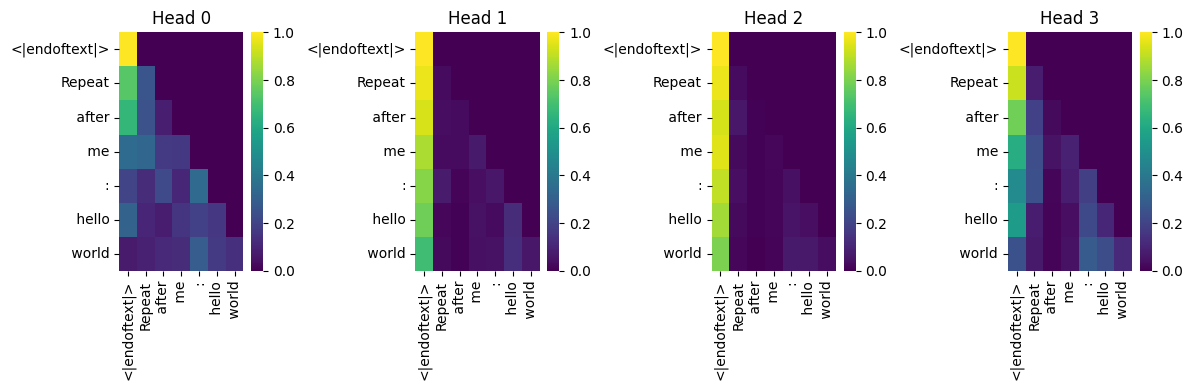


Text: 'Repeat after me: hello hello hello'
Predicted: ' hello' (prob: 0.194)


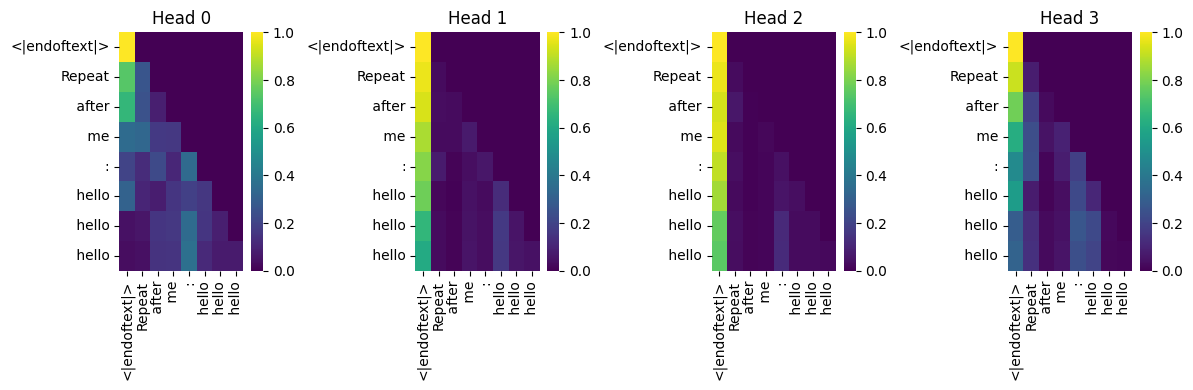


Text: 'Repeat after me: hello test'
Predicted: ',' (prob: 0.053)


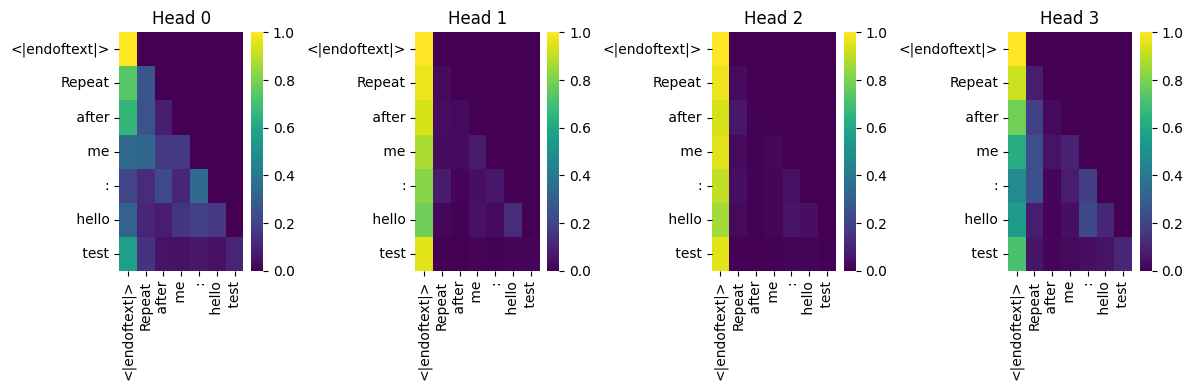


Copying Analysis Summary:
      variation predicted  probability  is_copy
0         hello         !     0.132097    False
1         world         ,     0.224976    False
2   hello hello     hello     0.193999    False
3          test         ,     0.053173    False


In [ ]:
def analyze_copying_behavior(model, base_text, variations):
    """
    Analyze how the model handles copying and repetition.
    """
    results = []
    
    for variation in variations:
        full_text = base_text + variation
        logits, cache = model.run_with_cache(full_text)
        
        # Get predictions
        next_token_probs = torch.softmax(logits[0, -1], dim=0)
        top_prob, top_token = torch.topk(next_token_probs, 1)
        
        predicted_token = model.to_string(top_token[0])
        results.append({
            'variation': variation,
            'predicted': predicted_token,
            'probability': top_prob[0].item(),
            'is_copy': predicted_token.strip() == variation.strip()
        })
        
        # Analyze attention patterns for copying
        print(f"\nText: '{full_text}'")
        print(f"Predicted: '{predicted_token}' (prob: {top_prob[0].item():.3f})")
        
        # Visualize final layer attention
        final_attn = cache["blocks.11.attn.hook_pattern"][0]
        plt.figure(figsize=(12, 4))
        
        for head in range(min(4, model.cfg.n_heads)):  # Show first 4 heads
            plt.subplot(1, 4, head+1)
            attn_data = final_attn[head].detach().cpu().numpy()
            token_labels = model.to_str_tokens(full_text)
            sns.heatmap(attn_data, cmap='viridis', 
                       xticklabels=token_labels, yticklabels=token_labels)
            plt.title(f'Head {head}')
        
        plt.tight_layout()
        plt.show()
    
    return pd.DataFrame(results)

# Test copying behavior
base = "Repeat after me: hello"
variations = [" hello", " world", " hello hello", " test"]
copying_results = analyze_copying_behavior(model, base, variations)
print("\nCopying Analysis Summary:")
print(copying_results)

**7.2 Circuit Analysis for Mathematical Reasoning**

In [ ]:
def analyze_arithmetic_circuit(model):
    """
    Analyze how the model performs simple arithmetic.
    """
    arithmetic_problems = [
        "2 + 3 =", "5 + 7 =", "10 + 15 =", "100 + 200 =",
        "2 * 3 =", "5 * 7 =", "10 * 15 =", "100 * 200 ="
    ]
    
    results = []
    
    for problem in arithmetic_problems:
        logits, cache = model.run_with_cache(problem)
        next_token_probs = torch.softmax(logits[0, -1], dim=0)
        
        # Get top 3 predictions
        top_probs, top_tokens = torch.topk(next_token_probs, 3)
        
        predictions = []
        for prob, token in zip(top_probs, top_tokens):
            token_str = model.to_string(token)
            predictions.append(f"'{token_str}': {prob.item():.3f}")
        
        results.append({
            'problem': problem,
            'predictions': ', '.join(predictions),
            'correct': any(model.to_string(token).strip() in problem for token in top_tokens)
        })
        
        print(f"Problem: {problem}")
        print(f"Top predictions: {', '.join(predictions)}")
        
        # Analyze which heads attend to numbers
        final_attn = cache["blocks.11.attn.hook_pattern"][0]
        token_labels = model.to_str_tokens(problem)
        
        # Find number positions
        number_positions = [i for i, token in enumerate(token_labels) 
                           if token.strip().isdigit()]
        
        if number_positions:
            print(f"Number positions: {number_positions}")
            
            # Check if any head strongly attends to numbers
            for head in range(model.cfg.n_heads):
                number_attention = final_attn[head, -1, number_positions].mean().item()
                if number_attention > 0.3:  # Threshold for "strong" attention
                    print(f"  Head {head} attends to numbers: {number_attention:.3f}")
    
    return pd.DataFrame(results)

# Analyze arithmetic capabilities
arithmetic_results = analyze_arithmetic_circuit(model)

Problem: 2 + 3 =
Top predictions: ' 4': 0.114, ' 3': 0.095, ' 2': 0.084
Number positions: [1, 3]
Problem: 5 + 7 =
Top predictions: ' 6': 0.055, ' 5': 0.053, ' 8': 0.051
Number positions: [1, 3]
Problem: 10 + 15 =
Top predictions: ' 1': 0.041, ' 10': 0.038, ' 2': 0.031
Number positions: [1, 3]
Problem: 100 + 200 =
Top predictions: ' 100': 0.064, ' 1': 0.053, ' 200': 0.035
Number positions: [1, 3]
Problem: 2 * 3 =
Top predictions: ' 4': 0.105, ' 1': 0.082, ' 3': 0.071
Number positions: [1, 3]
Problem: 5 * 7 =
Top predictions: ' 1': 0.058, ' 8': 0.052, ' 4': 0.045
Number positions: [1, 3]
Problem: 10 * 15 =
Top predictions: ' 1': 0.050, ' 15': 0.038, ' 10': 0.038
Number positions: [1, 3]
Problem: 100 * 200 =
Top predictions: ' 1': 0.090, ' 100': 0.071, ' 200': 0.046
Number positions: [1, 3]


### 8. Advanced Applications

**8.1 Automated Circuit Discovery**

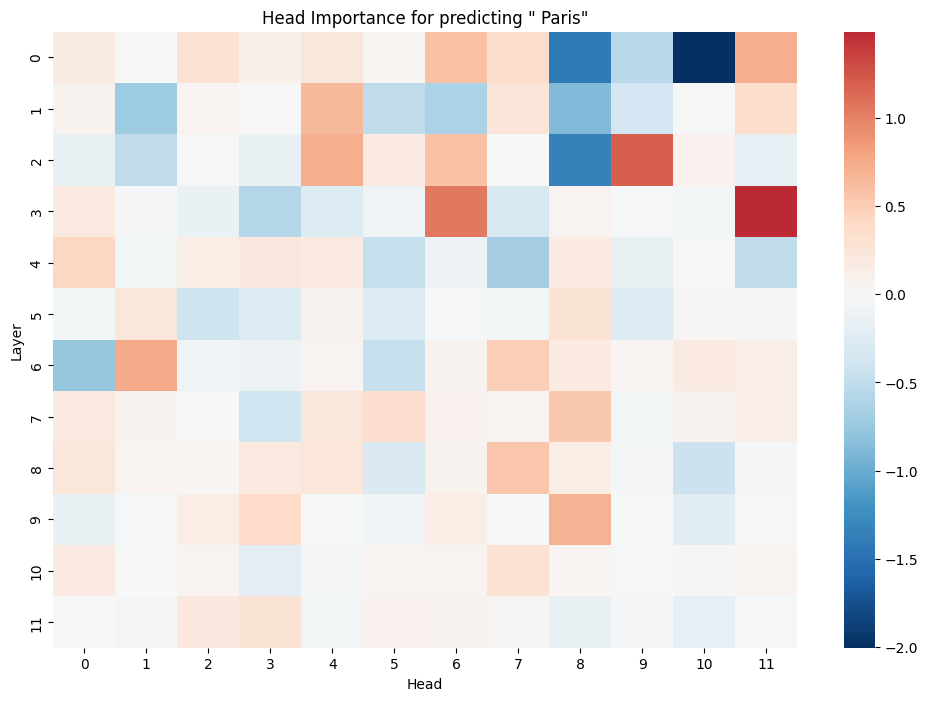

Top 10 most important heads:
Layer 0, Head 10: importance=-2.0040
Layer 3, Head 11: importance=1.4884
Layer 0, Head 8: importance=-1.4272
Layer 2, Head 8: importance=-1.3373
Layer 2, Head 9: importance=1.1976
Layer 3, Head 6: importance=1.0486
Layer 1, Head 8: importance=-0.8805
Layer 6, Head 0: importance=-0.7707
Layer 6, Head 1: importance=0.7633
Layer 2, Head 4: importance=0.7325


In [ ]:
def find_important_heads(model, text, target_token):
    """
    Identify which attention heads are most important for specific predictions.
    """
    base_logits, base_cache = model.run_with_cache(text)
    target_idx = model.to_single_token(target_token)
    base_score = base_logits[0, -1, target_idx].item()
    
    head_importance = []
    
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            # Ablate this head by zeroing its output
            def ablate_head_hook(value, hook):
                value[:, :, head, :] = 0  # Zero out this head's output
                return value
            
            # Run with ablated head
            ablated_logits = model.run_with_hooks(
                text,
                fwd_hooks=[(f"blocks.{layer}.attn.hook_z", ablate_head_hook)]
            )
            
            ablated_score = ablated_logits[0, -1, target_idx].item()
            importance = base_score - ablated_score  # How much performance drops
            
            head_importance.append({
                'layer': layer,
                'head': head,
                'importance': importance,
                'base_score': base_score,
                'ablated_score': ablated_score
            })
    
    # Sort by importance
    head_importance.sort(key=lambda x: abs(x['importance']), reverse=True)
    
    # Plot results
    importance_matrix = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)
    
    for result in head_importance:
        importance_matrix[result['layer'], result['head']] = result['importance']
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_matrix.detach().cpu().numpy(), 
                cmap='RdBu_r', center=0,
                xticklabels=range(model.cfg.n_heads),
                yticklabels=range(model.cfg.n_layers))
    plt.title(f'Head Importance for predicting "{target_token}"')
    plt.xlabel('Head')
    plt.ylabel('Layer')
    plt.show()
    
    print("Top 10 most important heads:")
    for result in head_importance[:10]:
        print(f"Layer {result['layer']}, Head {result['head']}: importance={result['importance']:.4f}")
    
    return head_importance

# Example: Find heads important for predicting "Paris"
important_heads = find_important_heads(model, "The capital of France is", " Paris")

**8.2 Visualization Toolkit**

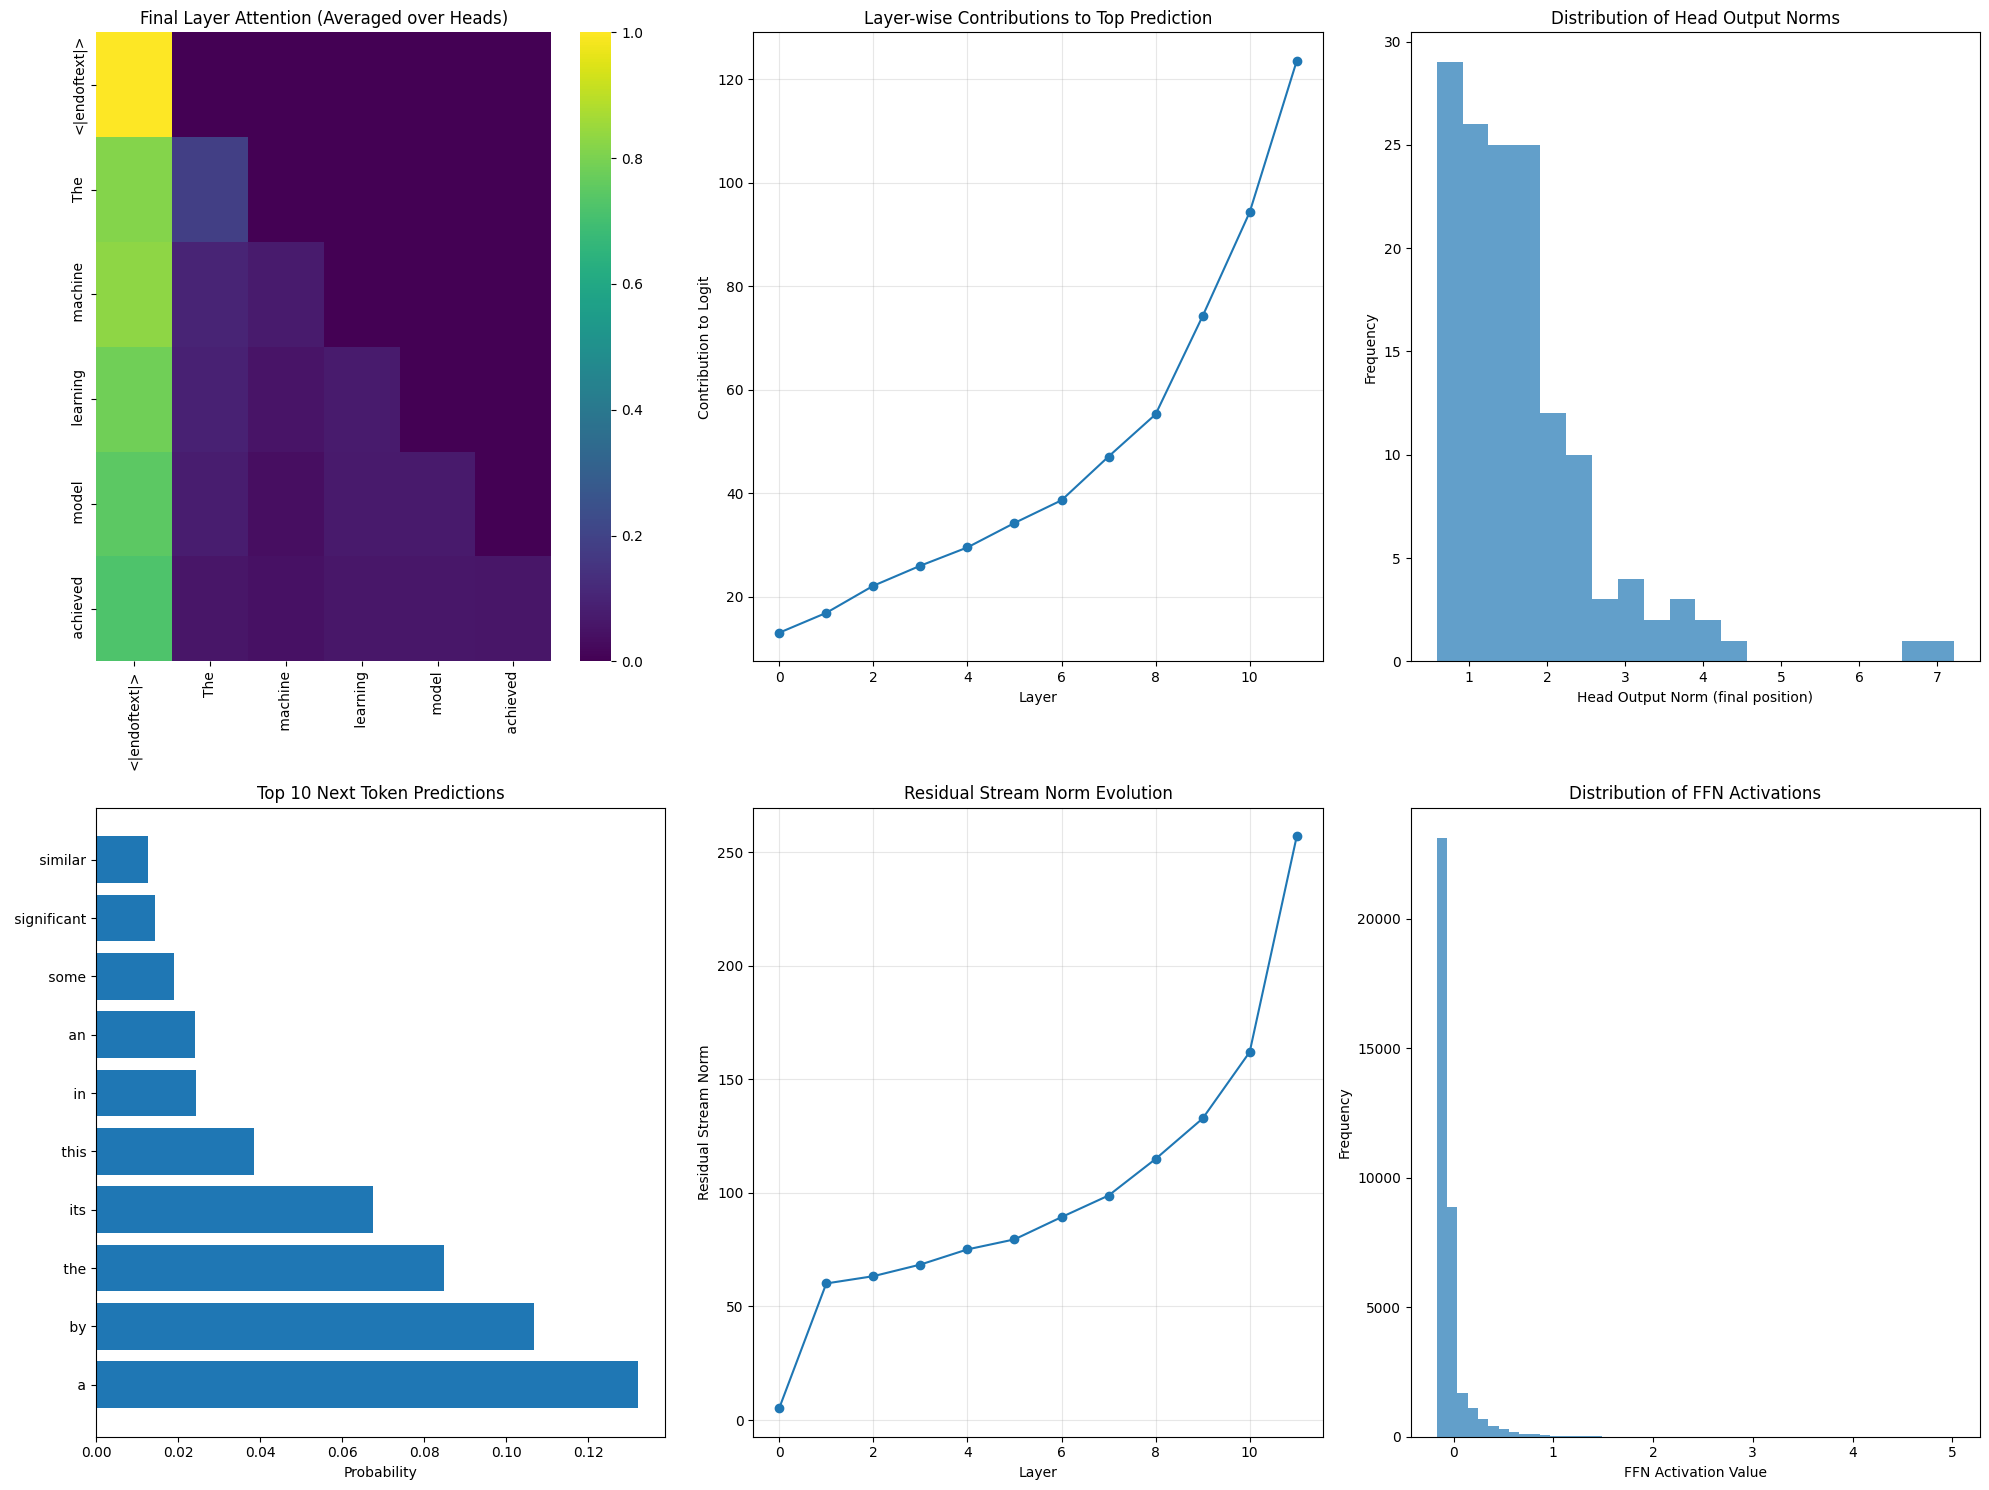

Input text: 'The machine learning model achieved'
Top prediction: ' a'
Prediction confidence: 0.132


In [ ]:
def create_interpretability_dashboard(model, text):
    """
    Create a comprehensive dashboard for model interpretability.
    """
    logits, cache = model.run_with_cache(text)
    tokens = model.to_str_tokens(text)
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Attention pattern overview (final layer)
    plt.subplot(2, 3, 1)
    final_attn = cache["blocks.11.attn.hook_pattern"][0].mean(dim=0)  # Average over heads
    sns.heatmap(final_attn.detach().cpu().numpy(), 
                xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title('Final Layer Attention (Averaged over Heads)')
    
    # 2. Layer-wise logit contributions
    plt.subplot(2, 3, 2)
    next_token_idx = logits[0, -1].argmax()
    W_U = model.W_U
    
    layer_contributions = []
    for layer in range(model.cfg.n_layers):
        layer_residual = cache[f"blocks.{layer}.hook_resid_post"][0, -1]
        contribution = (layer_residual @ W_U[:, next_token_idx]).item()
        layer_contributions.append(contribution)
    
    plt.plot(range(model.cfg.n_layers), layer_contributions, marker='o')
    plt.xlabel('Layer')
    plt.ylabel('Contribution to Logit')
    plt.title('Layer-wise Contributions to Top Prediction')
    plt.grid(True, alpha=0.3)
    
    # 3. Head importance distribution
    plt.subplot(2, 3, 3)
    head_output_norms = []
    for layer in range(model.cfg.n_layers):
        head_outputs = cache[f"blocks.{layer}.attn.hook_z"][0, -1]
        norms = torch.norm(head_outputs, dim=-1)
        head_output_norms.extend(norms.detach().cpu().numpy())
    
    plt.hist(head_output_norms, bins=20, alpha=0.7)
    plt.xlabel('Head Output Norm (final position)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Head Output Norms')
    
    # 4. Token probability distribution
    plt.subplot(2, 3, 4)
    final_probs = torch.softmax(logits[0, -1], dim=0)
    top_probs, top_indices = torch.topk(final_probs, 10)
    
    top_tokens = [model.to_string(idx) for idx in top_indices]
    plt.barh(range(len(top_tokens)), top_probs.detach().cpu().numpy())
    plt.yticks(range(len(top_tokens)), top_tokens)
    plt.xlabel('Probability')
    plt.title('Top 10 Next Token Predictions')
    
    # 5. Residual stream evolution
    plt.subplot(2, 3, 5)
    residual_norms = []
    for layer in range(model.cfg.n_layers):
        resid_pre = cache[f"blocks.{layer}.hook_resid_pre"][0, -1]
        resid_norm = torch.norm(resid_pre).item()
        residual_norms.append(resid_norm)
    
    plt.plot(range(model.cfg.n_layers), residual_norms, marker='o')
    plt.xlabel('Layer')
    plt.ylabel('Residual Stream Norm')
    plt.title('Residual Stream Norm Evolution')
    plt.grid(True, alpha=0.3)
    
    # 6. FFN activation distribution
    plt.subplot(2, 3, 6)
    ffn_activations = []
    for layer in range(model.cfg.n_layers):
        ffn_out = cache[f"blocks.{layer}.mlp.hook_post"][0, -1]
        ffn_activations.extend(ffn_out.detach().cpu().numpy())
    
    plt.hist(ffn_activations, bins=50, alpha=0.7)
    plt.xlabel('FFN Activation Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of FFN Activations')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Input text: '{text}'")
    print(f"Top prediction: '{model.to_string(next_token_idx)}'")
    print(f"Prediction confidence: {final_probs[next_token_idx].item():.3f}")

# Create dashboard for our example
create_interpretability_dashboard(model, "The machine learning model achieved")

### 9. Conclusion
Through this deep dive into TransformerLens, we've uncovered several key insights:

**Key Findings**
1. *Architecture Understanding*: TransformerLens provides unprecedented access to transformer internals, allowing us to examine every component from attention heads to FFN neurons.
2. *Mechanistic Interpretability*: The library enables causal analysis through techniques like activation patching and ablation studies, moving beyond correlation to causation.
3. *Circuit Discovery*: We can identify specific computational circuits responsible for different capabilities like copying, arithmetic, and grammatical reasoning.
4. *Scalable Analysis*: The tools scale from simple diagnostic tests to comprehensive analyses of real AI systems.

**Eductaional Insights:**
-  *Accessibility:* While the underlying concepts are complex, TransformerLens provides an accessible interface for students and researchers.
-  *Visualization:* The combination of numerical analysis and visualization makes abstract concepts concrete.
-  *Experimental Framework:* The library encourages an experimental approach to understanding AI systems.